In [3]:
import pandas as pd
df = pd.read_csv("../data/clean_ecomm_data.csv")
df.head()


,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub-category,product_name,sales,order_year,order_month,order_week
0,1,CA-2017-152156,2017-08-11,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2017.0,8.0,32.0
1,2,CA-2017-152156,2017-08-11,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,2017.0,8.0,32.0
2,3,CA-2017-138688,2017-12-06,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2017.0,12.0,49.0
3,4,US-2016-108966,2016-11-10,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,2016.0,11.0,45.0
4,5,US-2016-108966,2016-11-10,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2016.0,11.0,45.0


In [4]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')


In [6]:
df.columns


Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'order_year', 'order_month', 'order_week'],
      dtype='object')

In [7]:
df.columns.tolist()


['row_id',
 'order_id',
 'order_date',
 'ship_date',
 'ship_mode',
 'customer_id',
 'customer_name',
 'segment',
 'country',
 'city',
 'state',
 'postal_code',
 'region',
 'product_id',
 'category',
 'sub-category',
 'product_name',
 'sales',
 'order_year',
 'order_month',
 'order_week']

In [8]:
today = df['order_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (today - x.max()).days,   # Recency
    'order_id': 'count',                              # Frequency
    'sales': 'sum'                                    # Monetary
})

rfm.rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'sales': 'monetary'
}, inplace=True)

rfm.head()


,recency,frequency,monetary
customer_id,,,
AA-10315,649.0,11,5563.560
AA-10375,30.0,15,1056.390
AA-10480,1347.0,12,1790.512
AA-10645,215.0,18,5086.935
AB-10015,427.0,6,886.156


In [12]:
today = df['order_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (today - x.max()).days,  # Recency
    'order_id': 'count',                             # Frequency
    'sales': 'sum'                                   # Monetary
})

rfm.rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'sales': 'monetary'
}, inplace=True)

rfm.head()


,recency,frequency,monetary
customer_id,,,
AA-10315,649.0,11,5563.560
AA-10375,30.0,15,1056.390
AA-10480,1347.0,12,1790.512
AA-10645,215.0,18,5086.935
AB-10015,427.0,6,886.156


In [18]:
rfm.isna().sum()


recency      57
frequency     0
monetary      0
r_score      57
f_score       0
m_score       0
dtype: int64

In [20]:
today = df['order_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (today - x.max()).days,
    'order_id': 'count',
    'sales': 'sum'
})

rfm.rename(columns={
    'order_date': 'recency',
    'order_id': 'frequency',
    'sales': 'monetary'
}, inplace=True)

rfm.head()


,recency,frequency,monetary
customer_id,,,
AA-10315,649.0,11,5563.560
AA-10375,30.0,15,1056.390
AA-10480,1347.0,12,1790.512
AA-10645,215.0,18,5086.935
AB-10015,427.0,6,886.156


In [21]:
rfm['recency'] = rfm['recency'].fillna(rfm['recency'].median())


In [22]:
rfm.isna().sum()


recency      0
frequency    0
monetary     0
dtype: int64

In [23]:
# Rank-based scoring
rfm['r_rank'] = rfm['recency'].rank(method='dense', ascending=True)
rfm['f_rank'] = rfm['frequency'].rank(method='dense', ascending=False)
rfm['m_rank'] = rfm['monetary'].rank(method='dense', ascending=False)

def scale(series):
    if series.max() == series.min():
        return pd.Series([3] * len(series), index=series.index)
    return ((series - series.min()) / (series.max() - series.min()) * 4 + 1).round()

rfm['r_score'] = scale(rfm['r_rank']).astype(int)
rfm['f_score'] = scale(rfm['f_rank']).astype(int)
rfm['m_score'] = scale(rfm['m_rank']).astype(int)

rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

rfm.head()


,recency,frequency,monetary,r_rank,f_rank,m_rank,r_score,f_score,m_score,rfm_score
customer_id,,,,,,,,,,
AA-10315,649.0,11,5563.560,196.0,25.0,90.0,4,4,1,9
AA-10375,30.0,15,1056.390,11.0,21.0,601.0,1,3,4,8
AA-10480,1347.0,12,1790.512,286.0,24.0,465.0,5,4,3,12
AA-10645,215.0,18,5086.935,73.0,18.0,112.0,2,3,2,7
AB-10015,427.0,6,886.156,140.0,30.0,647.0,3,4,4,11


In [24]:
def segment(row):
    score = row['rfm_score']
    if score >= 13:
        return "Champion"
    elif score >= 11:
        return "Loyal Customer"
    elif score >= 9:
        return "Potential Loyalist"
    elif score >= 7:
        return "Needs Attention"
    else:
        return "At Risk"

rfm['segment'] = rfm.apply(segment, axis=1)
rfm.head()


,recency,frequency,monetary,r_rank,f_rank,m_rank,r_score,f_score,m_score,rfm_score,segment
customer_id,,,,,,,,,,,
AA-10315,649.0,11,5563.560,196.0,25.0,90.0,4,4,1,9,Potential Loyalist
AA-10375,30.0,15,1056.390,11.0,21.0,601.0,1,3,4,8,Needs Attention
AA-10480,1347.0,12,1790.512,286.0,24.0,465.0,5,4,3,12,Loyal Customer
AA-10645,215.0,18,5086.935,73.0,18.0,112.0,2,3,2,7,Needs Attention
AB-10015,427.0,6,886.156,140.0,30.0,647.0,3,4,4,11,Loyal Customer


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


FileNotFoundError: [Errno 2] No such file or directory: '../images/rfm_segments.png'

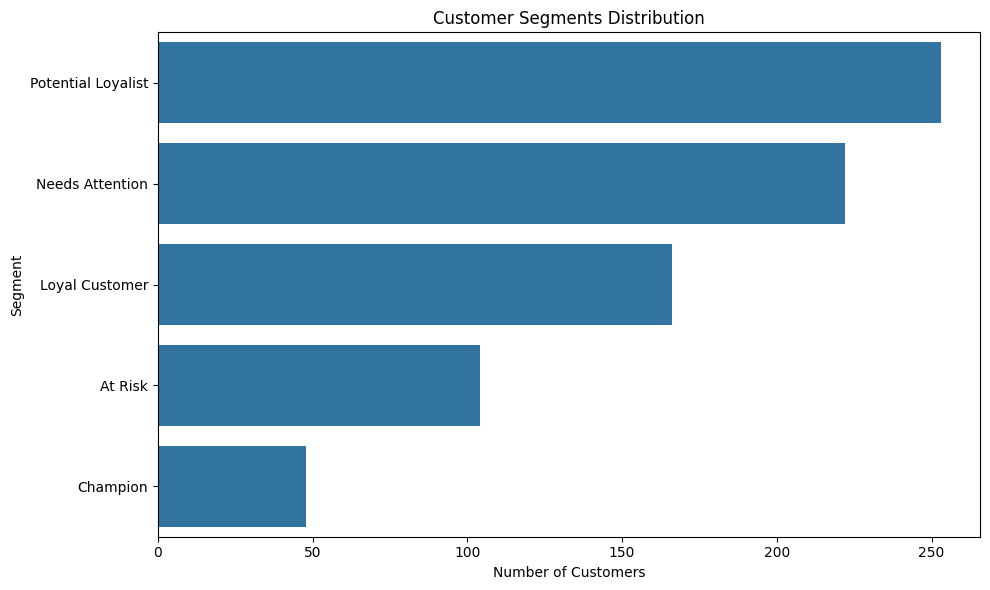

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(y=rfm['segment'], order=rfm['segment'].value_counts().index)
plt.title("Customer Segments Distribution")
plt.xlabel("Number of Customers")
plt.ylabel("Segment")
plt.tight_layout()
plt.savefig("../images/rfm_segments.png")
plt.show()


In [28]:
import os
os.makedirs("../images", exist_ok=True)


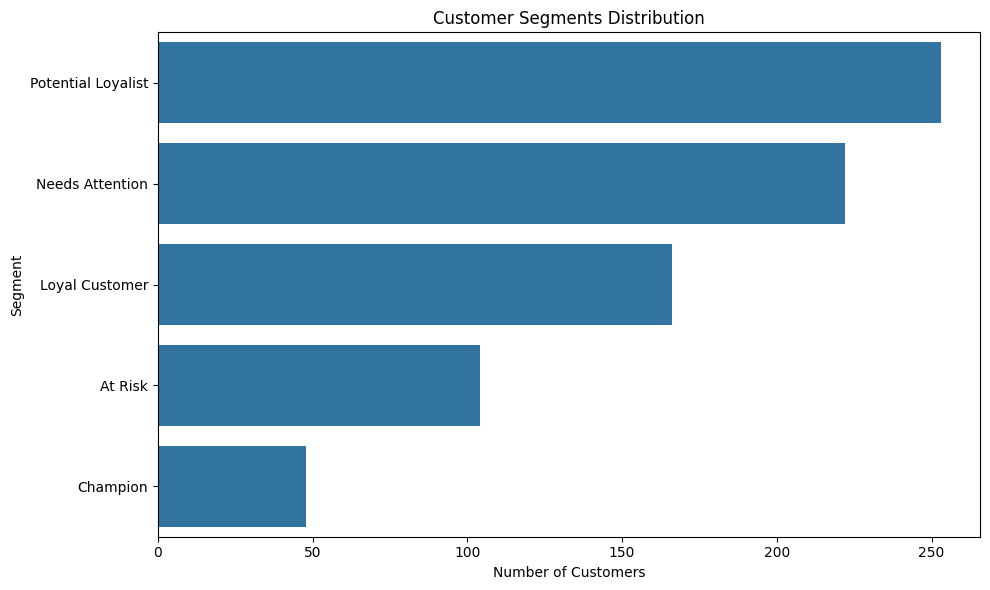

In [29]:
plt.figure(figsize=(10,6))
sns.countplot(y=rfm['segment'], order=rfm['segment'].value_counts().index)
plt.title("Customer Segments Distribution")
plt.xlabel("Number of Customers")
plt.ylabel("Segment")
plt.tight_layout()
plt.savefig("../images/rfm_segments.png")
plt.show()


In [30]:
rfm.to_csv("../reports/rfm_segments.csv", index=True)
